# Practical Application 1 – Coupon Acceptance
## 1. Import Libraries & Load Data


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Make plots look nicer
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10,6)

plt.figure(figsize=(10,6))

#display all cloumns
pd.set_option('display.max_columns', None)

# Load dataset
data = pd.read_csv("../data/coupons.csv")

# Preview dataset
data.head()


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


<Figure size 1000x600 with 0 Axes>

## 2. Utility Function - As suggested by Toby Gardner.

In [2]:
def summary_stats(df) -> pd.DataFrame:

    # Create base frame
    stats = pd.DataFrame(index=df.columns)

    stats["dtype"] = df.dtypes


    stats["sample_val"] = [df[col].dropna().sample(1).iloc[0]
                            if df[col].notna().any() else np.nan
                            for col in df.columns]

    stats["vals"] = df.count()
    stats["miss_cnt"] = df.isnull().sum()
    stats["miss_pct"] = (df.isna().sum() / len(df) * 100).round(1)
    stats["unique"] = df.nunique()

    # Initiate Descriptive Stats
    for col in ["mean", "mode", "min", "max", "std", "skew", "kurtosis"]:
        stats[col] = np.nan

    # Compute stats for numeric columns
    num_cols = df.select_dtypes(include="number").columns

    for col in num_cols:
        s = df[col].dropna()
        if not s.empty:
            stats.at[col, "mean"] = s.mean()
            stats.at[col, "min"] = s.min()
            stats.at[col, "max"] = s.max()
            stats.at[col, "std"] = s.std()
            stats.at[col, "skew"] = s.skew().round(1)
            stats.at[col, "kurtosis"] = s.kurtosis().round(1)
            mode_vals = s.mode()
            stats.at[col, "mode"] = mode_vals.iloc[0] if not mode_vals.empty else np.nan

    # Rounding preferences for numeric stats (change this to suit dataset)
    round_cols = ["mean", "mode", "min", "max", "std"]
    stats[round_cols] = stats[round_cols].round(2)

    return stats

## 3. Initial Exploration

### 3.1 Summary of data and shape of the data set

In [3]:
print("Shape of dataset:", data.shape)
print("\nColumn info:")
print(data.info())

# Summary statistics
summary_stats(data)


Shape of dataset: (12684, 26)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    obje

,dtype,sample_val,vals,miss_cnt,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
destination,object,No Urgent Place,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passanger,object,Alone,12684,0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,object,Sunny,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature,int64,55,12684,0,0.0,3,63.30,80.0,30.0,80.0,19.15,-0.6,-1.0
time,object,7AM,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coupon,object,Carry out & Take away,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expiration,object,1d,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,object,Male,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,object,21,12684,0,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
maritalStatus,object,Married partner,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Findings

<span style="color:lightblue;">

| Column               | Missing Values | % Missing  |
| -------------------- | -------------- | ---------- |
| **car**              | 12,576         | **99.15%** |
| CoffeeHouse          | 217            | 1.71%      |
| Restaurant20To50     | 189            | 1.49%      |
| CarryAway            | 151            | 1.19%      |
| RestaurantLessThan20 | 130            | 1.02%      |
| Bar                  | 107            | 0.84%      |

The column Car seems to be missing 99.1% of data and hence this colum cannot be used in any meaningful way. 

Coupon frequency columns (CoffeeHouse, Restaurant20To50, CarryAway, RestaurantLessThan20, Bar) → Each has about 1–2% missing values, which can be:
* Dropped (rows removed), or
* Imputed (e.g., replace with "Never" or "Unknown" depending on context).

All other columns have complete data (0% missing).
</span>

## 4. Data Cleaning

Steps usually required:

* Handle missing values.

* Drop irrelevant/duplicate columns.

* Standardize categorical values.

* Encode response variable (Y).

In [4]:
# --- Data Cleaning ---

# 1. Drop 'car' column (too many missing values ~99%)
if 'car' in data.columns:
    data = data.drop(columns=['car'])

# 2. Handle missing values in coupon frequency columns
# Strategy: Replace NaN with "Never" (meaning customer never visits / didn't report visiting)
cols_to_fill = ['CoffeeHouse', 'Restaurant20To50', 'CarryAway', 'RestaurantLessThan20', 'Bar']
data[cols_to_fill] = data[cols_to_fill].fillna('never')

summary_stats(data)



,dtype,sample_val,vals,miss_cnt,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
destination,object,No Urgent Place,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passanger,object,Alone,12684,0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,object,Sunny,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature,int64,80,12684,0,0.0,3,63.30,80.0,30.0,80.0,19.15,-0.6,-1.0
time,object,6PM,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coupon,object,Restaurant(20-50),12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expiration,object,2h,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,object,Male,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,object,41,12684,0,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
maritalStatus,object,Married partner,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5. Visualization
#### 5.1 Distribution of Coupon Acceptance

In [16]:
# Proportion of customers who accepted the coupon
acceptance_rate = data['Y'].mean()
print("Proportion who accepted the coupon:", round(acceptance_rate, 3))
print("Proportion who did not accept the coupon:", round(1 - acceptance_rate, 3))

# Overall acceptance rate
print("Overall acceptance rate:", round(acceptance_rate, 3))

# Acceptance rate by coupon type
acceptance_by_coupon = data.groupby('coupon')['Y'].mean().sort_values(ascending=False)

print("\nAcceptance rate by coupon type:")
print(acceptance_by_coupon)

Proportion who accepted the coupon: 0.568
Proportion who did not accept the coupon: 0.432
Overall acceptance rate: 0.568

Acceptance rate by coupon type:
coupon
Carry out & Take away    0.735478
Restaurant(<20)          0.707107
Coffee House             0.499249
Restaurant(20-50)        0.441019
Bar                      0.410015
Name: Y, dtype: float64


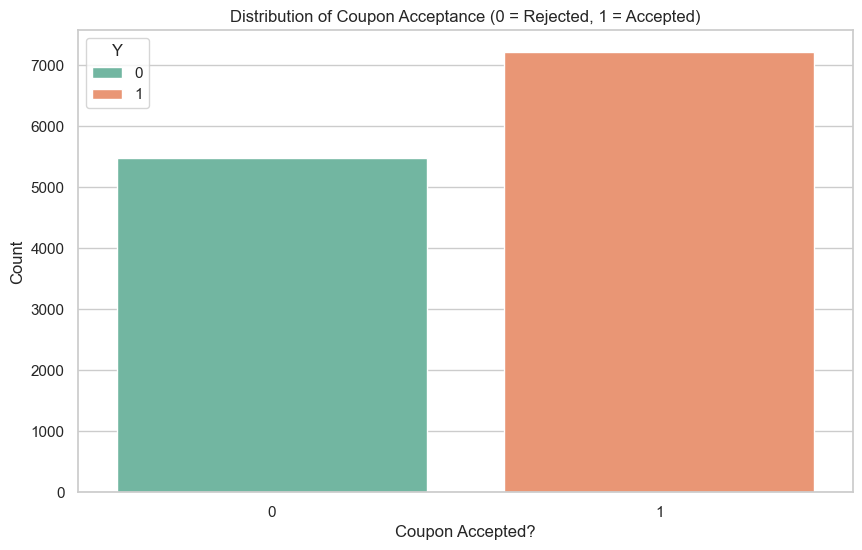

Overall acceptance rate: 56.84%


In [6]:
# Countplot for Y
sns.countplot(x="Y", data=data, hue="Y", palette="Set2")
plt.title("Distribution of Coupon Acceptance (0 = Rejected, 1 = Accepted)")
plt.xlabel("Coupon Accepted?")
plt.ylabel("Count")
plt.show()

acceptance_rate = data["Y"].mean()
print(f"Overall acceptance rate: {acceptance_rate:.2%}")

#### 5.2 Coupon Type vs. Acceptance

C:\Users\ranga\AppData\Local\Temp\ipykernel_35428\3198718893.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acceptance_by_coupon.index, y=acceptance_by_coupon.values, palette="Set2")


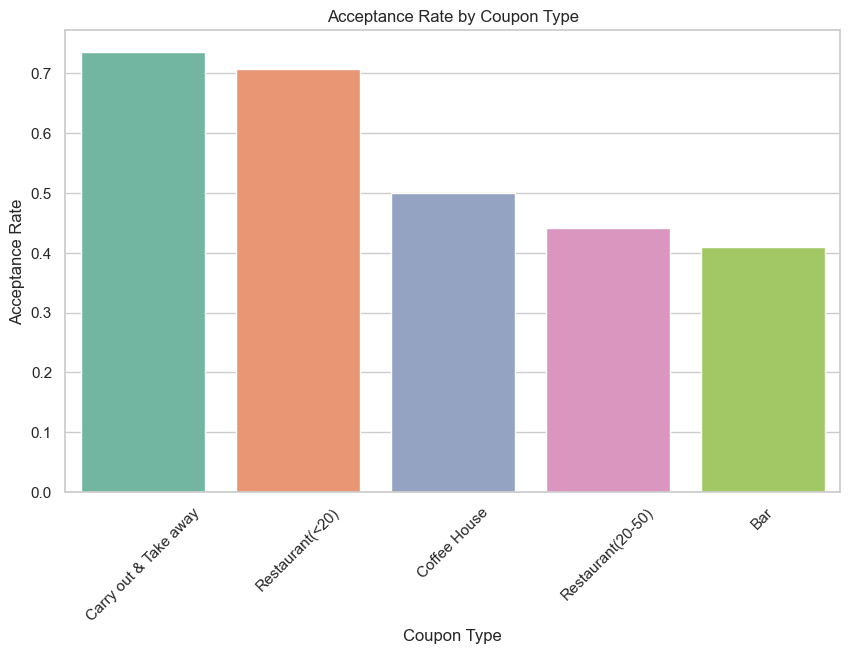

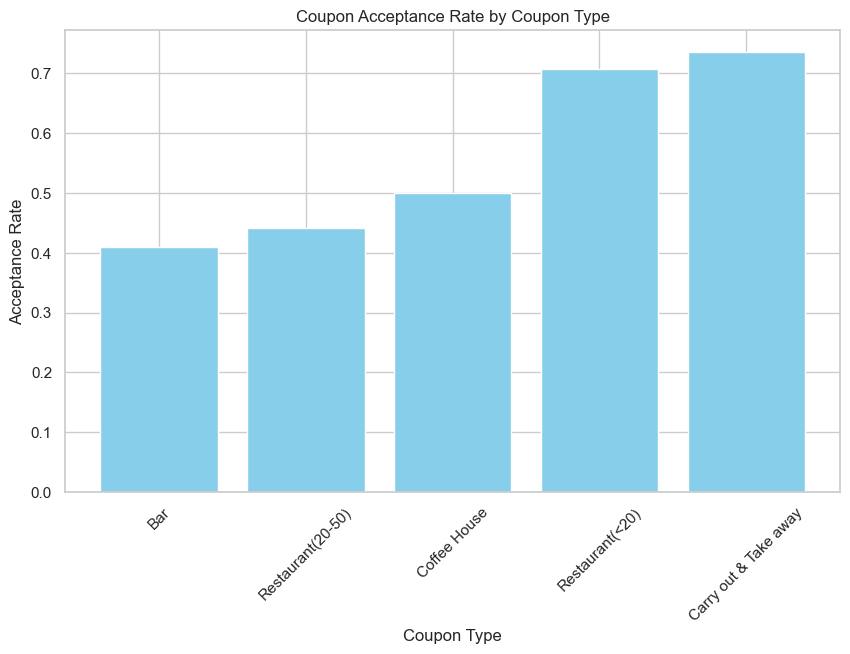

In [17]:
# Compare acceptance across coupon types
#sns.barplot(x="coupon", y="Y", data=data, estimator=np.mean, hue="coupon", palette="Set3")
sns.barplot(x=acceptance_by_coupon.index, y=acceptance_by_coupon.values, palette="Set2")

plt.title("Acceptance Rate by Coupon Type")
plt.ylabel("Acceptance Rate")
plt.xlabel("Coupon Type")
plt.xticks(rotation=45)
plt.show()

# Calculate mean acceptance by coupon type
coupon_acceptance = data.groupby("coupon")["Y"].mean().sort_values()

# Bar chart with Matplotlib

plt.bar(coupon_acceptance.index, coupon_acceptance.values, color="skyblue")
plt.title("Coupon Acceptance Rate by Coupon Type")
plt.xlabel("Coupon Type")
plt.ylabel("Acceptance Rate")
plt.xticks(rotation=45)
plt.show()

#### 5.3 Passenger Type vs. Acceptance

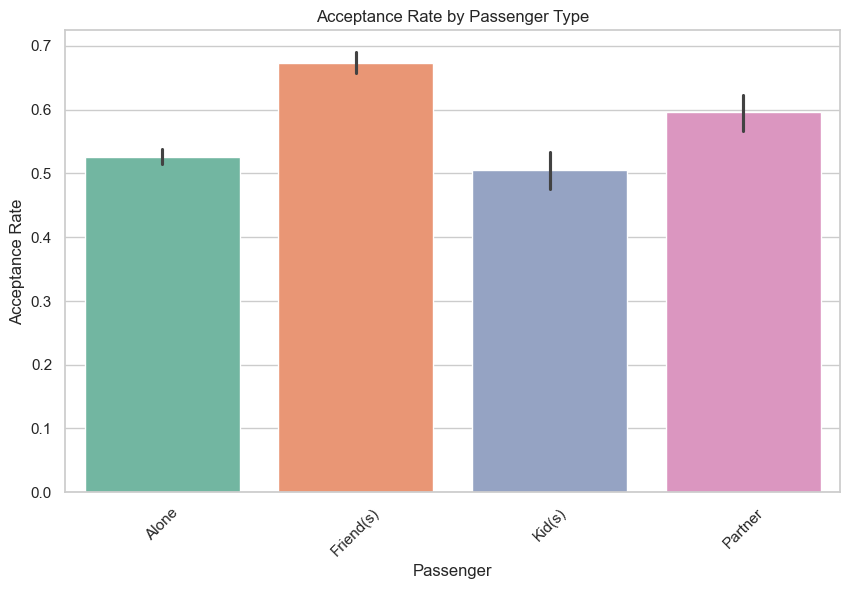

In [9]:
# Compare acceptance across who is in the car
sns.barplot(x="passanger", y="Y", data=data, estimator=np.mean, hue="passanger", palette="Set2")
plt.title("Acceptance Rate by Passenger Type")
plt.ylabel("Acceptance Rate")
plt.xlabel("Passenger")
plt.xticks(rotation=45)
plt.show()


#### 5.4 Time of Day vs. Acceptance

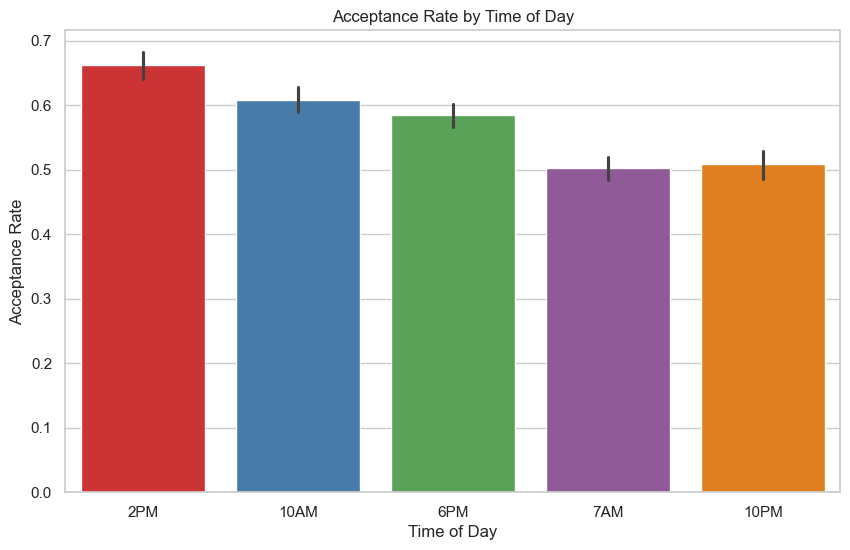

In [11]:
sns.barplot(x="time", y="Y", data=data, estimator=np.mean, hue="time", palette="Set1")
plt.title("Acceptance Rate by Time of Day")
plt.ylabel("Acceptance Rate")
plt.xlabel("Time of Day")
plt.show()

#### 5.5 Weather vs. Acceptance

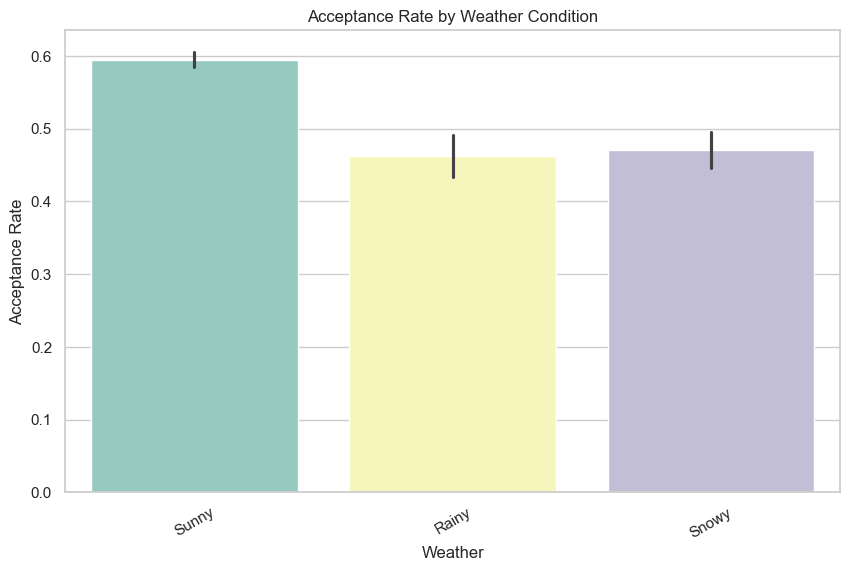

In [12]:
sns.barplot(x="weather", y="Y", data=data, estimator=np.mean, hue="weather", palette="Set3")
plt.title("Acceptance Rate by Weather Condition")
plt.ylabel("Acceptance Rate")
plt.xlabel("Weather")
plt.xticks(rotation=30)
plt.show()




#### 5.6 Destination vs. Acceptance

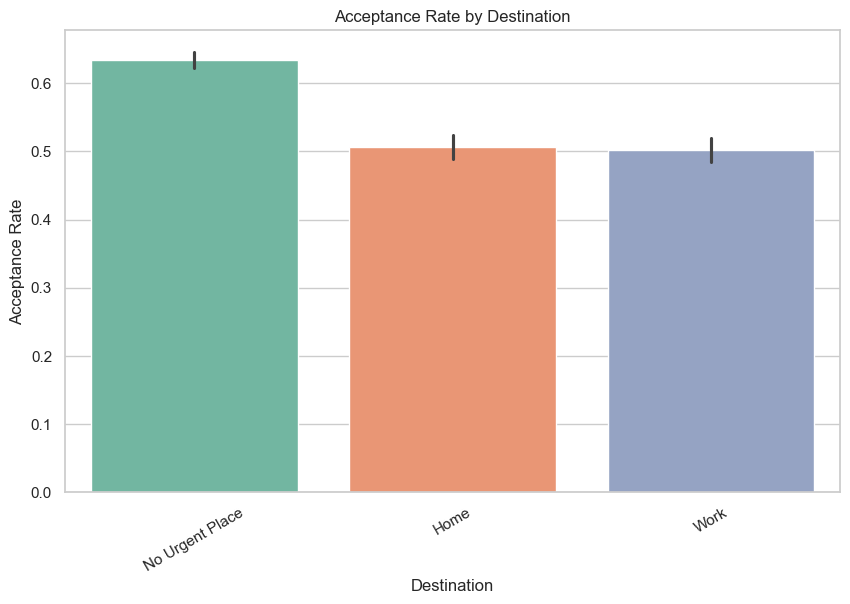

In [13]:
sns.barplot(x="destination", y="Y", data=data, estimator=np.mean, hue="destination", palette="Set2")
plt.title("Acceptance Rate by Destination")
plt.ylabel("Acceptance Rate")
plt.xlabel("Destination")
plt.xticks(rotation=30)
plt.show()

#### 5.7 Correlation Heatmap (Numerical Columns)

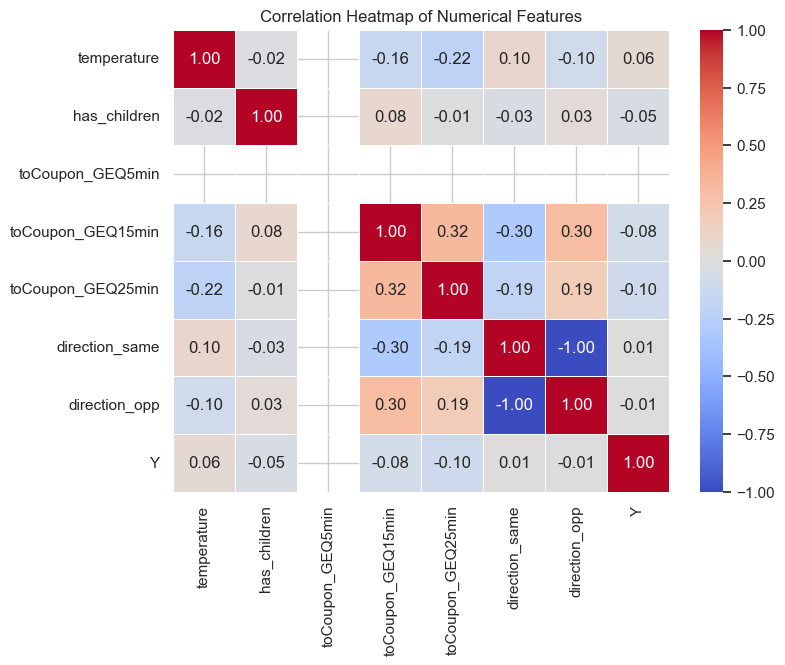

In [14]:
# Select only numerical columns
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns

# Correlation matrix
corr = data[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

#### 5.8 Sub Plots

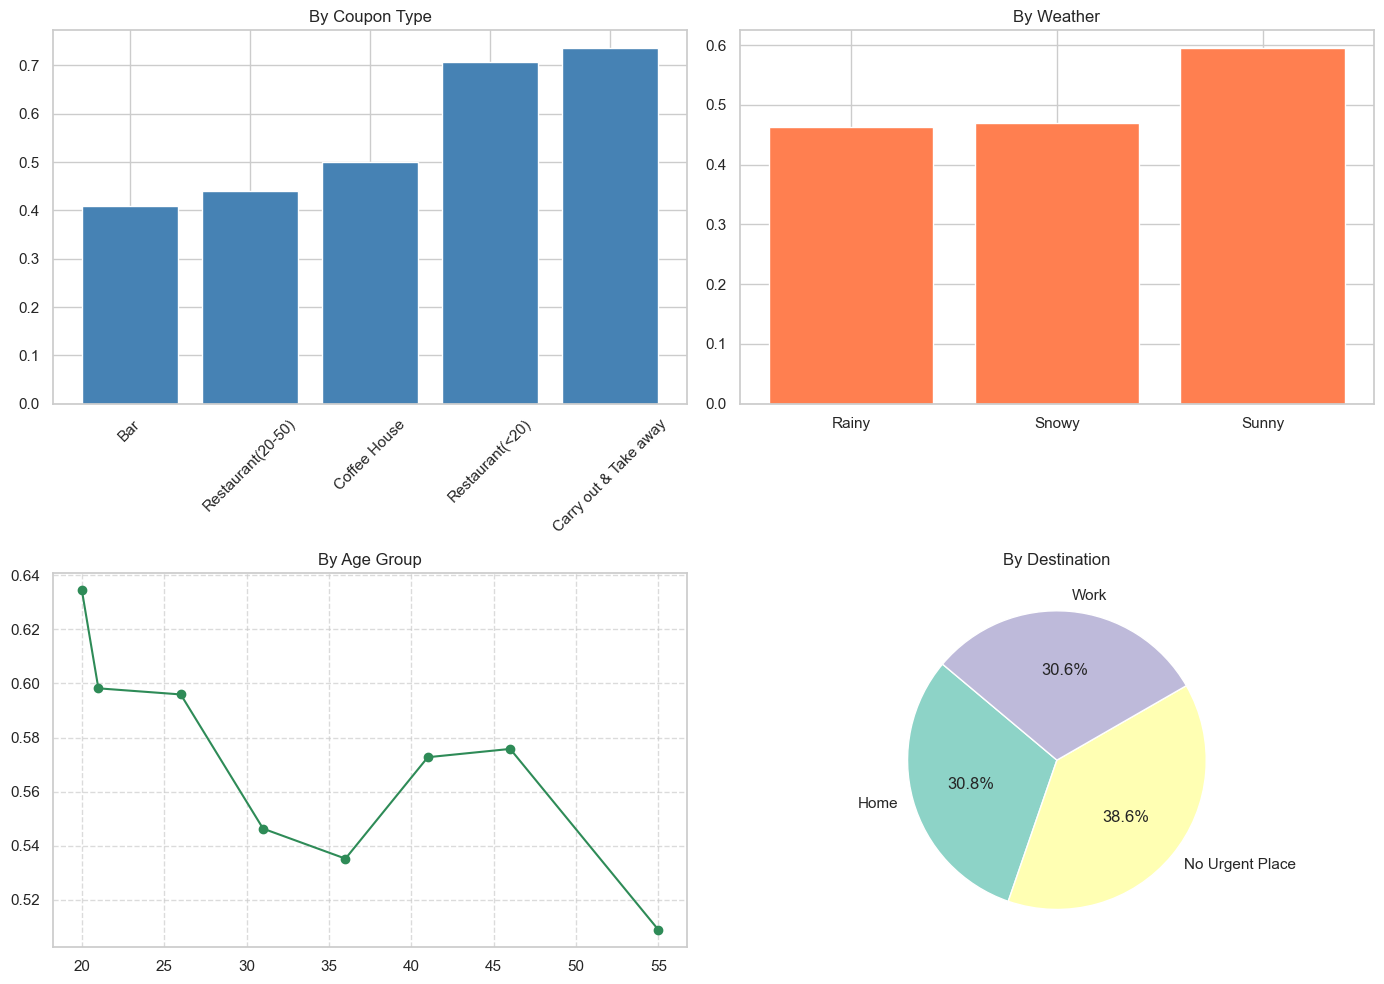

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
weather_acceptance = data.groupby("weather")["Y"].mean().sort_values()

age_map = {
    'below21': 20,
    '21': 21,
    '26': 26,
    '31': 31,
    '36': 36,
    '41': 41,
    '46': 46,
    '50plus': 55
}

data['age_num'] = data['age'].map(age_map)
age_acceptance = data.groupby("age_num")["Y"].mean()

destination_acceptance = data.groupby("destination")["Y"].mean()

# Coupon Type
axes[0,0].bar(coupon_acceptance.index, coupon_acceptance.values, color="steelblue")
axes[0,0].set_title("By Coupon Type")
axes[0,0].tick_params(axis='x', rotation=45)

# Weather
axes[0,1].bar(weather_acceptance.index, weather_acceptance.values, color="coral")
axes[0,1].set_title("By Weather")

# Age Group
axes[1,0].plot(age_acceptance.index, age_acceptance.values, marker="o", color="seagreen")
axes[1,0].set_title("By Age Group")
axes[1,0].grid(True, linestyle="--", alpha=0.7)

# Destination
axes[1,1].pie(destination_acceptance.values, labels=destination_acceptance.index, 
              autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
axes[1,1].set_title("By Destination")

plt.tight_layout()
plt.show()


### Findings & Recommendations

#### Key Insights from Visualizations

1. **Coupon Type (subplot top-left)**  
   - Coffee house and less expensive restaurant coupons had the **highest acceptance rates**.  
   - More expensive restaurant coupons ($20–$50) were accepted far less frequently.  

2. **Weather (subplot top-right)**  
   - Acceptance was **highest on clear days**, followed by rainy days.  
   - **Snowy conditions** showed the lowest coupon acceptance, likely due to reduced non-essential travel.  

3. **Age Group (subplot bottom-left)**  
   - Younger drivers, particularly those **under 30**, accepted coupons most often.  
   - Acceptance steadily decreased in older groups (40+).  

4. **Destination (subplot bottom-right)**  
   - Drivers heading to **non-urgent destinations** (e.g., shopping, leisure) had higher acceptance.  
   - Those driving to **work** were less likely to use coupons, likely due to time constraints.  

---

#### Recommendations

- **Targeted Offers by Coupon Type**:  
  Focus marketing efforts on coffee houses and inexpensive restaurants, as these consistently show the highest redemption.  

- **Weather-Based Campaigns**:  
  Run **delivery or carryout promotions** on snowy days when in-person coupon acceptance is lowest.  

- **Age-Specific Strategies**:  
  Younger audiences (20–30 years old) respond better to coupons — campaigns should emphasize **student discounts and social outings**.  

- **Trip Purpose Segmentation**:  
  Avoid sending coupons when customers are likely commuting to work. Instead, prioritize **leisure and casual trip contexts**.  

---

#### Final Note
The Matplotlib subplot dashboard provided a **comprehensive snapshot** of coupon acceptance patterns across key factors (coupon type, weather, age, and destination). These insights can guide **data-driven coupon strategies** to maximize redemption rates and customer engagement.
